<a href="https://colab.research.google.com/github/aminejarraya/ImageClef-Lifelog-2020/blob/main/DenseNet201_on_ImageCLEF_Lifelog_Dataset.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Introduction


In this notebook, we implement [Densenet201](https://keras.io/api/applications/densenet/#densenet201-function) for training on the [ImageCLEF Lifelog Dataset](https://www.imageclef.org/2020/lifelog).

#Import Drive
Import your drive into your Goole Colab's content

In [ ]:
from google.colab import drive
drive.mount("/content/drive/")

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive/


#Import Packages
Import the necessary packages

In [ ]:
import pandas as pd
import tensorflow as tf
from tensorflow.keras.callbacks import *
from sklearn.preprocessing import MultiLabelBinarizer
from tensorflow.keras.applications import DenseNet201
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras import optimizers
import matplotlib.pyplot as plt
import tensorflow.keras.backend as K
import numpy as np
import cv2
from tensorflow.keras.models import  Model 
from tensorflow.keras.layers import Dense
from keras.applications.densenet import preprocess_input

#Load Dataset
Reading csv file from Drive

In [ ]:
cop = pd.read_csv("/content/drive/My Drive/Kilua.csv")

/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (80,82,83,85,86,88,89,91,92,94,95,97,98,100,101,103,104,106,107,109,110,112,113,115,116,118,119,121,122,124,125,127,128,130,131,133,134,136,137,139,140,142,143,145,146,148,149,151,152,154,155,157,158,160,161,163,164,166,167,169,170,172,173,175,176,178,179,181,182,184,185,187,188,190,191,193,194,196) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [ ]:
#Convert tags from String to list of Strings
import ast 
for i in range(cop.shape[0]):
  cop['tags'][i] = ast.literal_eval(cop['tags'][i]) 

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


#Image Preprocessing
Generating Images with ImageDataGenerator Library

In [ ]:
#We will accept the original data, randomly transforms it, and returns only a new transformed rescaled data
#Initialize an our data augmenter as an "empty" image data generator for training and validation
train_image_generator = ImageDataGenerator(rescale=1.0/255.0) 
validation_image_generator = ImageDataGenerator(rescale=1./255) 


In [ ]:
#Add new column to csv file called index which contains index from 1 to number of images
#Index is simply sample index that acts as a helper for retrieving the corresponding samples later on
cop['index'] = cop.index

In [ ]:
#Exploring data's shape
cop.shape[0]

190865

In [ ]:
#Manually divide data into 80% for training and 20% to validate the model
print(int(0.8*190865))
print(int(0.2*190865))

152692
38173


Define Generators for training

In [ ]:
#Read the images from a big numpy array , folders containing images and defining parameters
#The reason why tags is used directly in y_col is simply because Keras does not allow reading object type from DataFrame
# The trick here is to use filename to be the x_col and index to be the y_col. 
#The idea is that we aim to get the location in the dataframe so as to retrieve the tags later on
train_data_gen = train_image_generator.flow_from_dataframe(dataframe=cop.iloc[0:152692],#we only get the training images
                                                           directory = "/content/drive/My Drive/imageclef2020", #directory which contains images
                                                           x_col="image_path", 
                                                           y_col="index",
                                                           batch_size=128, #each step contains 128 samples 
                                                           shuffle=True, #images will be putted randomly
                                                           target_size=(224, 224), #the size of images must match the same size of the first model's layer which will be defined later
                                                           seed=42,
                                                           class_mode = "other" 
                                                          )

Found 152692 validated image filenames.


Multi-Label Binarizer

In [ ]:
#If we can successfully retrieve the tags, what is left is to apply a multi-label binarizer to it
from sklearn.preprocessing import MultiLabelBinarizer
mlb = MultiLabelBinarizer()
mlb.fit(cop['tags'].values)

MultiLabelBinarizer(classes=None, sparse_output=False)

In [ ]:
#list the all the classes we have
list(mlb.classes_)

['',
 ' Dublin',
 ' Dundrum Town Centre',
 ' Gardermoen',
 ' Gate 53',
 ' Killester',
 ' Langnes (TOS)',
 ' Liffey Valley Center',
 ' Thai and Vietnamese Takeaway',
 ' Tromsoe',
 ' a DoubleTree by Hilton Hotel',
 'Airside Retail Park',
 'Airside retail park',
 "Angelina's",
 "Ann's Bakery and Restaurant",
 'Arisu Korean Restrant',
 'Arnotts Department Store',
 'Austies Bar and Restaurant',
 'Avoca',
 'B&Q',
 'Ballsbridge Hotel',
 'Bayside',
 'Boots Liffey Valley',
 'Brown Thomas',
 'Café Rouge',
 'Caim Church',
 'Captain Americas Cookhouse & Bar',
 'Car Rental Village',
 'Clarion Hotel & Congress Oslo Airport',
 'Clarion Hotel The Edge',
 'Collins Park',
 'Connolly Train Station',
 'Costa Coffee',
 "Crabby Jo's Restaurant",
 'DAA Executive Lounge',
 'DCU Engineering Building',
 'DCU Restaurant',
 'DCU School of Computing',
 'DCU School of Nursing',
 'DCU Staff CarPark (Albert College)',
 'Dentist Kilbarrack',
 'Dentistry.ie',
 'Devonshire Arms',
 'Donaghmede Shopping Centre',
 'Dublin 

In [ ]:
def multilabel_flow_from_dataframe(data_generator, mlb,df):
    for x, y in data_generator:
        indices = y.astype(np.int).tolist()
        y_multi = mlb.transform(
            df.iloc[indices]['tags'].values.tolist()
        )
        yield x, y_multi

In [ ]:
#Retrieve the tags
multilabel_generator_train = multilabel_flow_from_dataframe(
    train_data_gen, mlb,cop
)

Define Generators for Validation

In [ ]:
#Apply the same concept for validation
val_data_gen = validation_image_generator.flow_from_dataframe(dataframe = cop.iloc[152692:],
                                                             directory="/content/drive/My Drive/imageclef2020",
                                                             x_col = "image_path",
                                                             y_col = "index",
                                                             shuffle = True,
                                                             batch_size=128,
                                                             target_size=(224, 224),
                                                             seed=42,
                                                             class_mode='other')

Found 38173 validated image filenames.


In [ ]:
multilabel_generator_val = multilabel_flow_from_dataframe(
    val_data_gen,mlb,cop
)

#Define Metrics and Model
Define Custom Metrics

In [ ]:
#We're dealing with an imbalanced data that's why we will define custom metrics to visualize the progress of our model
#Recall function
def recall_m(y_true, y_pred):
  y_pred = backend.clip(y_pred, 0, 1)
  # calculate elements
  tp = backend.sum(backend.round(backend.clip(y_true * y_pred, 0, 1)), axis=1)
  fp = backend.sum(backend.round(backend.clip(y_pred - y_true, 0, 1)), axis=1)
  fn = backend.sum(backend.round(backend.clip(y_true - y_pred, 0, 1)), axis=1)
  r = tp / (tp + fn + backend.epsilon())
  return r
#Precision function
def precision_m(y_true, y_pred):
  y_pred = backend.clip(y_pred, 0, 1)
  # calculate elements
  tp = backend.sum(backend.round(backend.clip(y_true * y_pred, 0, 1)), axis=1)
  fp = backend.sum(backend.round(backend.clip(y_pred - y_true, 0, 1)), axis=1)
  fn = backend.sum(backend.round(backend.clip(y_true - y_pred, 0, 1)), axis=1)
  # calculate precision
  p = tp / (tp + fp + backend.epsilon())
  return p
#Fbeta function
def fbeta(y_true, y_pred, beta=2):
	# clip predictions
	y_pred = backend.clip(y_pred, 0, 1)
	# calculate elements
	tp = backend.sum(backend.round(backend.clip(y_true * y_pred, 0, 1)), axis=1)
	fp = backend.sum(backend.round(backend.clip(y_pred - y_true, 0, 1)), axis=1)
	fn = backend.sum(backend.round(backend.clip(y_true - y_pred, 0, 1)), axis=1)
	# calculate precision
	p = tp / (tp + fp + backend.epsilon())
	# calculate recall
	r = tp / (tp + fn + backend.epsilon())
	# calculate fbeta, averaged across each class
	bb = beta ** 2
	fbeta_score = backend.mean((1 + bb) * (p * r) / (bb * p + r + backend.epsilon()))
	return fbeta_score  

Define model

In [ ]:
def make_model():
  pre_trained_model = tensorflow.keras.applications.DenseNet201(include_top=False, weights="imagenet",input_tensor=tensorflow.keras.layers.Input(shape=(224, 224, 3)))
  # construct the head of the model that will be placed on top of the
  # the base model
  headModel = pre_trained_model.output
  headModel = tensorflow.keras.layers.AveragePooling2D(pool_size=(4, 4))(headModel)
  headModel = tensorflow.keras.layers.Flatten(name="flatten")(headModel)
  headModel = tensorflow.keras.layers.Dense(512, activation="relu")(headModel)
  headModel = tensorflow.keras.layers.Dropout(0.5)(headModel)
  headModel = tensorflow.keras.layers.Dense(len(mlb.classes_), activation="sigmoid")(headModel)

  # place the head FC model on top of the base model (this will become
  # the actual model we will train)
  model = tensorflow.keras.models.Model(inputs=pre_trained_model.input, outputs=headModel)

  # loop over all layers in the base model and freeze them so they will
  # *not* be updated during the first training process
  for layer in pre_trained_model.layers:
	  layer.trainable = False

  INIT_LR = 1e-3
  EPOCHS = 2
  # compile our model
  print("[INFO] compiling model...")
  opt = tensorflow.keras.optimizers.Adam(lr=INIT_LR, decay=INIT_LR / EPOCHS)
  model.compile(loss='binary_crossentropy',
                optimizer=opt,
                metrics=[fbeta,precision_m, recall_m])
  return model

In [ ]:
#Define a directory for the checkpoints
checkpoint_dir = '/content/drive/My Drive/CheckPoints'
if not os.path.exists(checkpoint_dir):
    os.makedirs(checkpoint_dir)

In [ ]:
def make_or_restore_model():
    # Either restore the latest model, or create a fresh one
    # if there is no checkpoint available.
    checkpoints = [checkpoint_dir + '/' + name
                   for name in os.listdir(checkpoint_dir)]
    if checkpoints:
        latest_checkpoint = max(checkpoints, key=os.path.getctime)
        print('Restoring from', latest_checkpoint)
        return tensorflow.keras.models.load_model(latest_checkpoint)
    print('Creating a new model')
    return make_model()

In [ ]:
model = make_or_restore_model()

Creating a new model
[INFO] compiling model...


In [ ]:
#Due to the big amount of data and the limiations provided by Google Colab,  we will define callbacks that saves a SavedModel every 20 batches.
callbacks = [
    # We include the training loss in the folder name.
    ModelCheckpoint(
        filepath=checkpoint_dir + '/ckpt-loss={loss:.2f}',
        save_freq=20),
        History(),
]

#Training Phase
Train our defined model

In [ ]:
H = model.fit_generator(multilabel_generator_train, steps_per_epoch=len(train_data_gen), validation_data=multilabel_generator_val, validation_steps=len(val_data_gen), epochs=2, verbose=1, callbacks=callbacks)

Epoch 1/2
  19/1193 [..............................] - ETA: 13:00:03 - loss: 0.2379 - fbeta: 0.3903 - precision_m: 0.3924 - recall_m: 0.4858WARNING:tensorflow:From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/resource_variable_ops.py:1817: calling BaseResourceVariable.__init__ (from tensorflow.python.ops.resource_variable_ops) with constraint is deprecated and will be removed in a future version.
Instructions for updating:
If using Keras pass *_constraint arguments to layers.
INFO:tensorflow:Assets written to: /content/drive/My Drive/CheckPoints/ckpt-loss=0.23/assets
  92/1193 [=>............................] - ETA: 12:52:46 - loss: 0.0955 - fbeta: 0.5385 - precision_m: 0.6556 - recall_m: 0.5398

Load Weights

In [ ]:
model = make_or_restore_model()

In [ ]:
#Colab gives us 2 hours and then the notebook automatically is shutted down
#We will load the last saved checkpoints using the load_weights function
model.load_weights('/content/drive/My Drive/epochs_test4(densenet201):002-val_fbeta:0.760.hdf5')

Compile the model

In [ ]:
#After loading weights, we need to compile the model again just like we did before in order to resume training
model.compile(loss='binary_crossentropy',
              optimizer=optimizer,
              metrics=[fbeta,precision_m, recall_m])

In [ ]:
H = model.fit_generator(multilabel_generator_train, steps_per_epoch=len(train_data_gen), validation_data=multilabel_generator_val, validation_steps=len(val_data_gen), epochs=6, verbose=1, callbacks=callbacks_list)

Instructions for updating:
Please use Model.fit, which supports generators.
Epoch 1/6
120/120 [==============================] - ETA: 0s - loss: 0.0205 - accuracy: 0.0074 - fbeta: 0.8738 - precision_m: 0.9299 - recall_m: 0.8634 
Epoch 00001: val_fbeta improved from -inf to 0.75886, saving model to /content/drive/My Drive/epochs_test4(densenet201):001-val_fbeta:0.759.hdf5
120/120 [==============================] - 8077s 67s/step - loss: 0.0205 - accuracy: 0.0074 - fbeta: 0.8738 - precision_m: 0.9299 - recall_m: 0.8634 - val_loss: 0.0395 - val_accuracy: 6.8381e-04 - val_fbeta: 0.7589 - val_precision_m: 0.8809 - val_recall_m: 0.7371
Epoch 2/6
120/120 [==============================] - ETA: 0s - loss: 0.0187 - accuracy: 0.0082 - fbeta: 0.8835 - precision_m: 0.9364 - recall_m: 0.8738 
Epoch 00002: val_fbeta improved from 0.75886 to 0.76017, saving model to /content/drive/My Drive/epochs_test4(densenet201):002-val_fbeta:0.760.hdf5
120/120 [==============================] - 2767s 23s/step - l

#Exploring Results
Explore some plots from trained batches

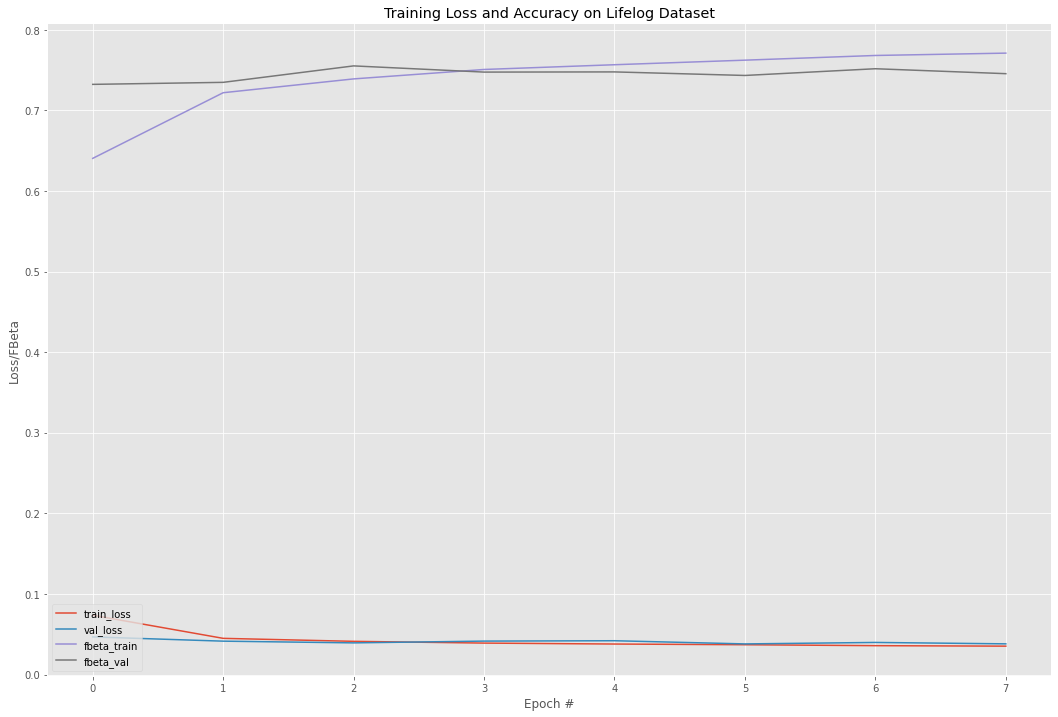

In [ ]:
N = 8
plt.style.use("ggplot")
plt.figure(figsize=(18, 12))
plt.plot(np.arange(0, N), H.history["loss"], label="train_loss")
plt.plot(np.arange(0, N), H.history["val_loss"], label="val_loss")
plt.plot(np.arange(0, N), H.history["fbeta"], label="fbeta_train")
plt.plot(np.arange(0, N), H.history["val_fbeta"], label="fbeta_val")
plt.title("Training Loss and Accuracy on Lifelog Dataset")
plt.xlabel("Epoch #")
plt.ylabel("Loss/FBeta")
plt.legend(loc="lower left")
plt.show()

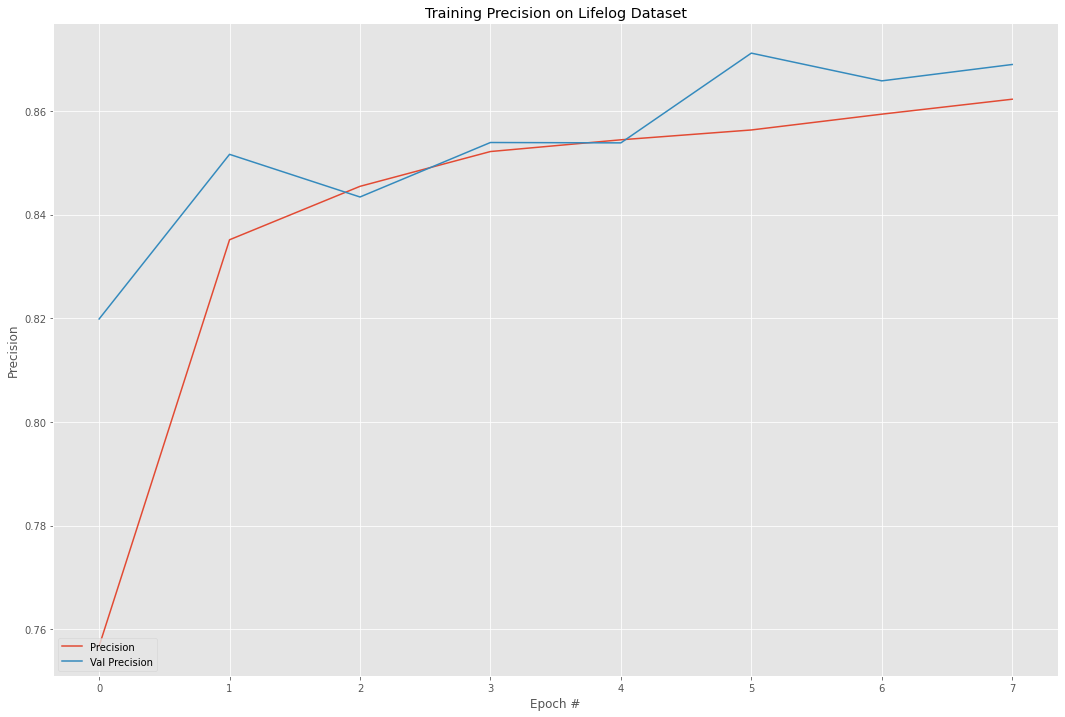

In [ ]:
N = 8
plt.style.use("ggplot")
plt.figure(figsize=(18, 12))
plt.plot(np.arange(0, N), H.history["precision_m"], label="Precision")
plt.plot(np.arange(0, N), H.history["val_precision_m"], label="Val Precision")
plt.title("Training Precision on Lifelog Dataset")
plt.xlabel("Epoch #")
plt.ylabel("Precision")
plt.legend(loc="lower left")
plt.show()

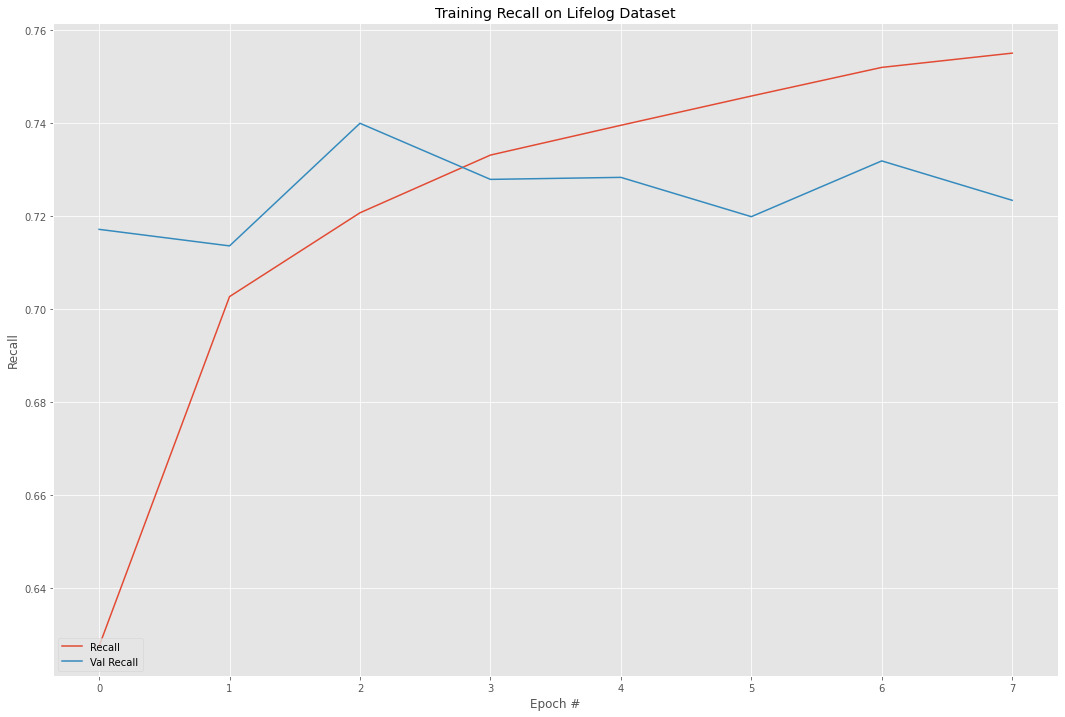

In [ ]:
N = 8
plt.style.use("ggplot")
plt.figure(figsize=(18, 12))
plt.plot(np.arange(0, N), H.history["recall_m"], label="Recall")
plt.plot(np.arange(0, N), H.history["val_recall_m"], label="Val Recall")
plt.title("Training Recall on Lifelog Dataset")
plt.xlabel("Epoch #")
plt.ylabel("Recall")
plt.legend(loc="lower left")
plt.show()

#Test Phase
Evaluate The Model and make predictions

In [ ]:
orig = cv2.imread("/content/drive/My Drive/B00012859_21I6X0_20180531_070210E.JPG")
inputShape = (224, 224)
preprocess = preprocess_input

In [ ]:
print("[INFO] loading and preprocessing image...")
image = load_img("/content/drive/My Drive/B00012859_21I6X0_20180531_070210E.JPG", target_size=inputShape)
image = img_to_array(image)

[INFO] loading and preprocessing image...


In [ ]:
image = np.expand_dims(image, axis=0)
image = preprocess(image)

In [ ]:
preds = model.predict(image)

In [ ]:
for i in range(len(mlb.classes_)):
    print("{}: {:.2f}%".format(mlb.classes_[i], preds[0][i] * 100))

aged: 0.30%
airfield: 0.01%
airplane: 0.36%
airplane_cabin: 26.43%
airport_terminal: 1.12%
alcove: 1.40%
alley: 0.01%
amphitheater: 0.00%
amusement_arcade: 0.00%
apartment_building/outdoor: 0.01%
apple: 0.09%
aquarium: 0.13%
aqueduct: 0.01%
arcade: 0.01%
archive: 0.01%
arena/performance: 0.11%
arena/rodeo: 0.01%
art_gallery: 0.02%
artists_loft: 0.28%
asphalt: 0.39%
atrium/public: 0.02%
attic: 0.26%
auditorium: 0.04%
backpack: 0.40%
bakery/shop: 0.15%
balcony/interior: 0.01%
ballroom: 0.00%
banana: 0.00%
bank_vault: 0.00%
banquet_hall: 0.19%
bar: 0.00%
baseball bat: 0.00%
basement: 0.02%
bathing: 0.02%
bathroom: 0.37%
bear: 0.00%
beauty_salon: 1.35%
bed: 1.21%
beer_hall: 0.07%
bench: 0.00%
berth: 4.93%
bicycle: 2.18%
biking: 0.10%
bird: 1.27%
boat: 0.01%
boat_deck: 0.00%
boating: 0.04%
book: 8.62%
bookstore: 0.04%
booth/indoor: 0.20%
bottle: 0.81%
bow_window/indoor: 0.08%
bowl: 2.91%
bowling_alley: 0.86%
boxing_ring: 0.05%
brick: 0.27%
bridge: 0.00%
broccoli: 0.30%
burial_chamber: 0.01%